In [23]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV

In [24]:
# Относительный путь к данным
df = pd.read_csv('../seminars/S05-hw-dataset.csv')

# первые 5 строк
print(df.head())

#информация о данных
print(df.info())

print(df.describe())

print(df['default'].value_counts())

print(df['default'].value_counts(normalize=True))


# Краткие наблюдения
print(f"Наблюдения: Всего объектов: {df.shape[0]}, признаков: {df.shape[1]}, явных аномалий не обнаружено, диапазон риска широкий, есть люди без сбережений")

   client_id  age  income  years_employed  credit_score  debt_to_income  \
0          1   25   94074              22           839        0.547339   
1          2   58   51884              26           565        0.290882   
2          3   53   48656              39           561        0.522340   
3          4   42   81492              30           582        0.709123   
4          5   42   94713               8           642        0.793392   

   num_credit_cards  num_late_payments  has_mortgage  has_car_loan  \
0                 1                  7             0             0   
1                 1                  1             0             1   
2                 1                 13             0             0   
3                 2                 10             1             1   
4                 3                  3             0             0   

   savings_balance  checking_balance  region_risk_score  \
0            26057              5229           0.080052   
1         

In [25]:
X = df.drop(['default', 'client_id'], axis=1)
y = df['default']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42,
    stratify=y  
)

In [26]:
dummy = DummyClassifier(strategy="most_frequent", random_state=42)
dummy.fit(X_train, y_train)

y_pred_dummy = dummy.predict(X_test)
y_pred_proba_dummy = dummy.predict_proba(X_test)[:, 1]  

acc_dummy = accuracy_score(y_test, y_pred_dummy)
roc_auc_dummy = roc_auc_score(y_test, y_pred_proba_dummy)

print("БЕЙЗЛАЙН МОДЕЛЬ (DummyClassifier)")
print("="*40)
print(f"Strategy: 'most_frequent' (всегда предсказывает 0)")
print(f"Accuracy на тесте: {acc_dummy:.4f}")
print(f"ROC-AUC на тесте: {roc_auc_dummy:.4f}")
print("Бейзлайн показывает минимальное качество, которое должна превзойти любая осмысленная модель.")
print(f"Accuracy = {acc_dummy:.1%} соответствует доле класса 0 в данных.")

БЕЙЗЛАЙН МОДЕЛЬ (DummyClassifier)
Strategy: 'most_frequent' (всегда предсказывает 0)
Accuracy на тесте: 0.5900
ROC-AUC на тесте: 0.5000
Бейзлайн показывает минимальное качество, которое должна превзойти любая осмысленная модель.
Accuracy = 59.0% соответствует доле класса 0 в данных.


In [30]:
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(max_iter=1000, random_state=42))
])

param_grid = {
    'logreg__C': [0.01, 0.1, 1.0, 10.0, 100.0],
    'logreg__penalty': ['l2']  
}

grid_search = GridSearchCV(
    pipe, 
    param_grid, 
    cv=5, 
    scoring='roc_auc',
    n_jobs=-1
)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
print(f"Лучшие параметры: {grid_search.best_params_}")
print(f"Лучший ROC-AUC (кросс-валидация): {grid_search.best_score_:.4f}")

Лучшие параметры: {'logreg__C': 100.0, 'logreg__penalty': 'l2'}
Лучший ROC-AUC (кросс-валидация): 0.8607


c:\Users\79084\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(


In [32]:
y_pred_lr = best_model.predict(X_test)
y_pred_proba_lr = best_model.predict_proba(X_test)[:, 1]

acc_lr = accuracy_score(y_test, y_pred_lr)
roc_auc_lr = roc_auc_score(y_test, y_pred_proba_lr)

print(f" Изначально Accuracy: {acc_lr:.4f}")
print(f"Изначально ROC-AUC: {roc_auc_lr:.4f}")
print(f"\nУлучшение accuracy: {acc_lr - acc_dummy:+.4f}")
print(f"Улучшение ROC-AUC: {roc_auc_lr - roc_auc_dummy:+.4f}")

 Изначально Accuracy: 0.8017
Изначально ROC-AUC: 0.8756

Улучшение accuracy: +0.2117
Улучшение ROC-AUC: +0.3756


График сохранен: figures/roc_curve.png


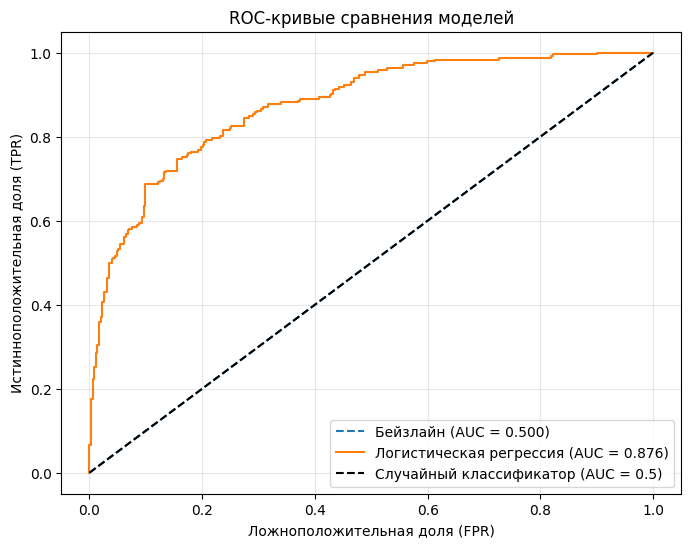

In [34]:
fpr_dummy, tpr_dummy, _ = roc_curve(y_test, y_pred_proba_dummy)
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred_proba_lr)

plt.figure(figsize=(8, 6))
plt.plot(fpr_dummy, tpr_dummy, label=f'Бейзлайн (AUC = {roc_auc_dummy:.3f})', linestyle='--')
plt.plot(fpr_lr, tpr_lr, label=f'Логистическая регрессия (AUC = {roc_auc_lr:.3f})')
plt.plot([0, 1], [0, 1], 'k--', label='Случайный классификатор (AUC = 0.5)')
plt.xlabel('Ложноположительная доля (FPR)')
plt.ylabel('Истинноположительная доля (TPR)')
plt.title('ROC-кривые сравнения моделей')
plt.legend()
plt.grid(True, alpha=0.3)

plt.savefig('figures/roc_curve.png', dpi=300, bbox_inches='tight')
print("График сохранен: figures/roc_curve.png")
plt.show()

In [39]:
results_df = pd.DataFrame({
    'Model': ['Dummy Classifier', 'Logistic Regression'],
    'Accuracy': [acc_dummy, acc_lr],
    'ROC-AUC': [roc_auc_dummy, roc_auc_lr],
    'Parameters': ["strategy='most_frequent'", f"C={grid_search.best_params_['logreg__C']}"]
})

print("Сравнение")
print(results_df.to_string(index=False))

print("\nВлияние на качество")
cv_results = pd.DataFrame(grid_search.cv_results_)
for params, mean_score in zip(cv_results['params'], cv_results['mean_test_score']):
    c_value = params['logreg__C']
    print(f"C = {c_value:6.2f} | ROC-AUC (CV) = {mean_score:.4f}")

Сравнение
              Model  Accuracy  ROC-AUC               Parameters
   Dummy Classifier  0.590000 0.500000 strategy='most_frequent'
Logistic Regression  0.801667 0.875649                  C=100.0

Влияние на качество
C =   0.01 | ROC-AUC (CV) = 0.8603
C =   0.10 | ROC-AUC (CV) = 0.8606
C =   1.00 | ROC-AUC (CV) = 0.8607
C =  10.00 | ROC-AUC (CV) = 0.8607
C = 100.00 | ROC-AUC (CV) = 0.8607


Бейзлайн модель просто предстазывает тот класс, который чаще встречается в данных, тоесть случайное угадывание Её accuracy составляет 59.0%, ROC-AUC равен 0.500 . А вот логистическая регрессия доаольно хорошо распределяет, модель улучшается, accuracy увеличилась на 21.2% (с 59.0% до 80.2%), ROC-AUC улучшился на 0.376 (с 0.500 до 0.876). Параметр регуляризации C почти не влиял на результат — при любых значениях от 0.01 до 100 качество было примерно одинаковым. Значит, модель устойчивая и не переобучается.